In [79]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False




In [73]:

db_path = '../../db/data/merge/tertiary/'

df = pd.read_csv(db_path + 'logs_.csv', index_col=0)

df.index = pd.to_datetime(df.index)

df

AUD       CAD       CHF       EUR       GBP  \
2005-01-03 00:00:00+00:00 -0.064396 -0.014073 -0.105662 -0.127787  0.028474   
2005-01-03 01:00:00+00:00 -0.006224 -0.067656 -0.119911 -0.035191 -0.030165   
2005-01-03 02:00:00+00:00 -0.085077  0.127799 -0.158482 -0.086595 -0.074298   
2005-01-03 03:00:00+00:00 -0.207331  0.163991 -0.154109 -0.154017 -0.036569   
2005-01-03 04:00:00+00:00 -0.066467 -0.044685  0.160728  0.142959  0.065867   
...                             ...       ...       ...       ...       ...   
2022-12-27 19:00:00+00:00 -0.102755  0.006377 -0.083646  0.198149  0.020712   
2022-12-27 20:00:00+00:00 -0.102755  0.006377 -0.083646  0.198149  0.020712   
2022-12-27 21:00:00+00:00 -0.102755  0.006377 -0.083646  0.198149  0.020712   
2022-12-27 22:00:00+00:00 -0.102755  0.006377 -0.083646  0.198149  0.020712   
2022-12-27 23:00:00+00:00 -0.102755  0.006377 -0.083646  0.198149  0.020712   

                                JPY       NZD       USD  
2005-01-03 00:00:00+00:00  0.172005 -0.015203  0.126642  
2005-01-03 01:00:00+00:00  0.148821  0.088015  0.022311  
2005-01-03 02:00:00+00:00  0.183128 -0.067183  0.160709  
2005-01-03 03:00:00+00:00 -0.339689  0.209851  0.517873  
2005-01-03 04:00:00+00:00  0.017020 -0.188196 -0.087227  
...                             ...       ...       ...  
2022-12-27 19:00:00+00:00 -0.054881 -0.035573  0.051618  
2022-12-27 20:00:00+00:00 -0.054881 -0.035573  0.051618  
2022-12-27 21:00:00+00:00 -0.054881 -0.035573  0.051618  
2022-12-27 22:00:00+00:00 -0.054881 -0.035573  0.051618  
2022-12-27 23:00:00+00:00 -0.054881 -0.035573  0.051618  

[111096 rows x 8 columns]

In [65]:
df.describe().transpose()

count      mean       std  min       25%       50%       75%       max
AUD  111096.0  0.177495  0.131799  0.0  0.106924  0.148457  0.205606  4.856685
CAD  111096.0  0.165026  0.111415  0.0  0.097938  0.136476  0.197787  2.522063
CHF  111096.0  0.157264  0.112038  0.0  0.092235  0.132377  0.186436  6.647650
EUR  111096.0  0.145264  0.094313  0.0  0.086030  0.122620  0.177581  2.581519
GBP  111096.0  0.160650  0.112124  0.0  0.094476  0.136191  0.192327  6.223761
JPY  111096.0  0.185950  0.144170  0.0  0.106980  0.148841  0.218719  7.181495
NZD  111096.0  0.193190  0.137622  0.0  0.116386  0.159170  0.227243  6.086339
USD  111096.0  0.153701  0.102832  0.0  0.090410  0.129966  0.184301  2.934883

Text(0, 0.5, 'JPY')

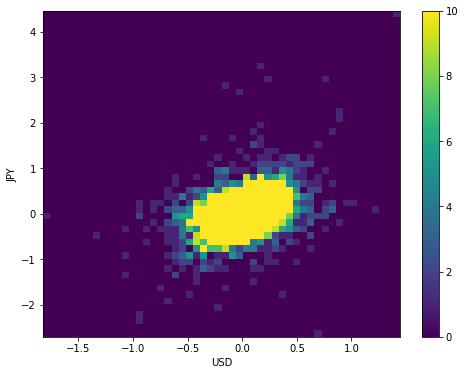

In [75]:

symbol = 'USD_JPY'

plt.hist2d(df[symbol[:3]], df[symbol[4:]], bins=(50, 50), vmax=10)
plt.colorbar()
plt.xlabel(symbol[:3])
plt.ylabel(symbol[4:])

Similar to the wind direction, the time in seconds is not a useful model input. Being weather data, it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

You can get usable signals by using sine and cosine transforms to clear "Time of day" and "Time of year" signals:


In [188]:
# TODO

day = 24*60*60
year = (365.2425)*day

df.index = df.index.values.astype(np.int64) // 10 ** 9

df['Day sin'] = np.sin(datetime.timestamp(df.index) * (2 * np.pi / day))
df['Day cos'] = np.cos(datetime.timestamp(df.index) * (2 * np.pi / day))
df['Year sin'] = np.sin(datetime.timestamp(df.index) * (2 * np.pi / year))
df['Year cos'] = np.cos(datetime.timestamp(df.index) * (2 * np.pi / year))

plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

TypeError: descriptor 'timestamp' for 'datetime.datetime' objects doesn't apply to a 'Int64Index' object

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important.

If you don't have that information, you can determine which frequencies are important by extracting features with Fast Fourier Transform. To check the assumptions, here is the tf.signal.rfft of the temperature over time. Note the obvious peaks at frequencies near 1/year and 1/day:

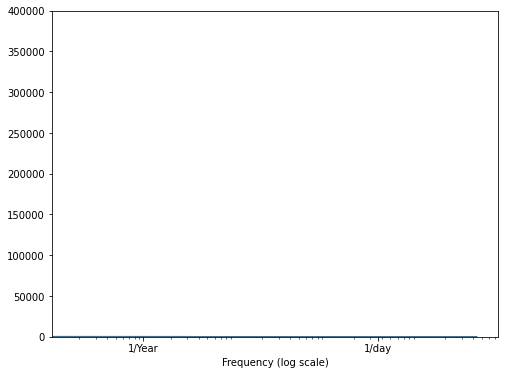

In [83]:
fft = tf.signal.rfft(df['AUD'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['AUD'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [85]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

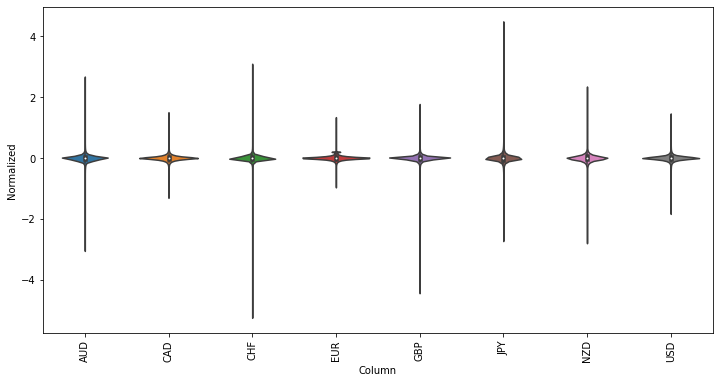

In [87]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [88]:
class WindowGenerator():

  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]


  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [96]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24)
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): None

In [98]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1)
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): None

In [99]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [100]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 8)
Inputs shape: (3, 6, 8)
Labels shape: (3, 1, 8)


In [101]:
w2.example = example_inputs, example_labels


In [113]:
def plot(self, model=None, plot_col='AUD', max_subplots=6):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

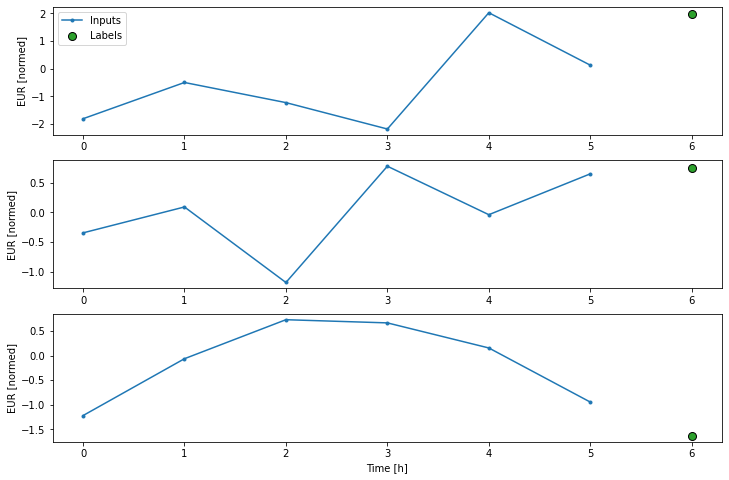

In [116]:
w2.plot(plot_col='EUR')

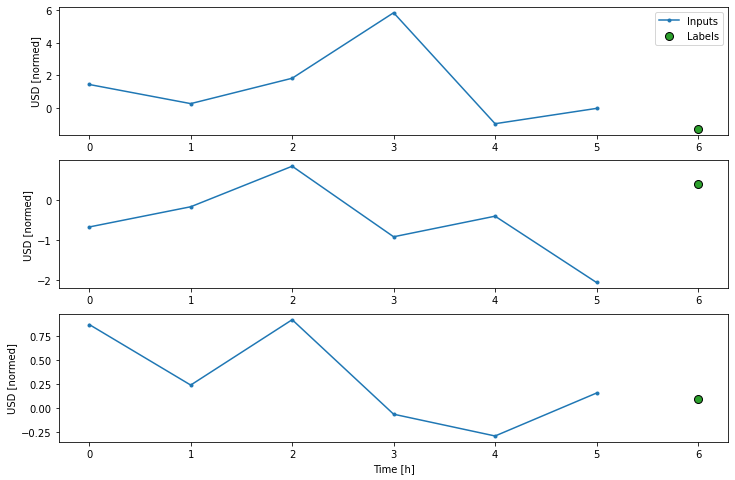

In [117]:
w2.plot(plot_col='USD')

In [118]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [119]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [120]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 8), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 8), dtype=tf.float32, name=None))

In [121]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 8)
Labels shape (batch, time, features): (32, 1, 8)


In [124]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['AUD'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['AUD']

In [125]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 8)
Labels shape (batch, time, features): (32, 1, 1)


In [126]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [127]:
baseline = Baseline(label_index=column_indices['AUD'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

695/695 [==============================] - 1s 1ms/step - loss: 1.0878 - mean_absolute_error: 0.6502


In [132]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['AUD'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['AUD']


This expanded window can be passed directly to the same baseline model without any code changes. This is possible because the inputs and labels have the same number of time steps, and the baseline just forwards the input to the output:

One prediction 1h into the future, ever hour.

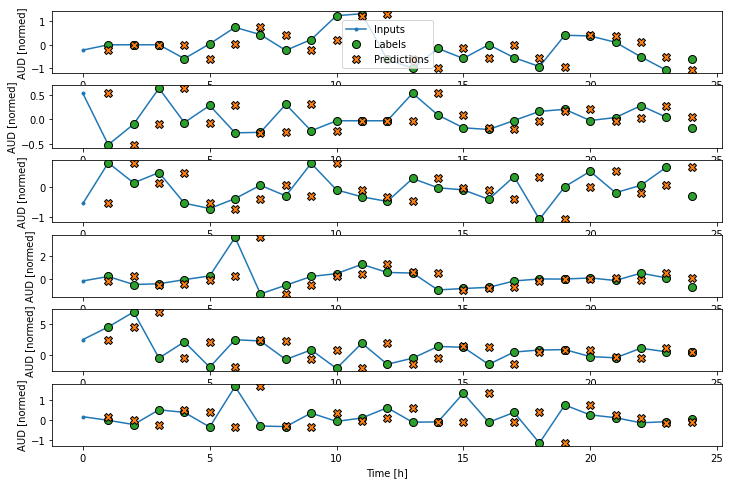

In [133]:
wide_window.plot(baseline)

In [134]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 8)
Output shape: (32, 1, 1)


In [157]:
MAX_EPOCHS = 10000

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [158]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/10000
2431/2431 [==============================] - 4s 2ms/step - loss: 0.9996 - mean_absolute_error: 0.6207 - val_loss: 0.5225 - val_mean_absolute_error: 0.4508
Epoch 2/10000
2431/2431 [==============================] - 4s 2ms/step - loss: 0.9998 - mean_absolute_error: 0.6206 - val_loss: 0.5225 - val_mean_absolute_error: 0.4508
Epoch 3/10000
2431/2431 [==============================] - 4s 2ms/step - loss: 0.9998 - mean_absolute_error: 0.6207 - val_loss: 0.5225 - val_mean_absolute_error: 0.4508
Epoch 4/10000
695/695 [==============================] - 1s 1ms/step - loss: 0.5225 - mean_absolute_error: 0.4508


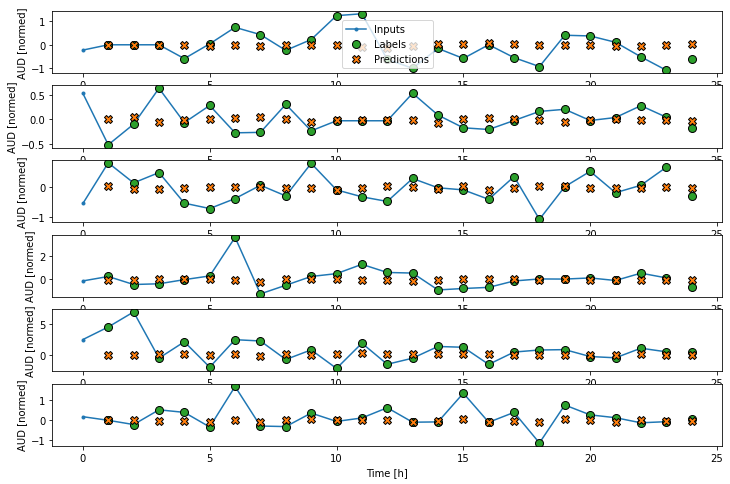

In [143]:
wide_window.plot(linear)


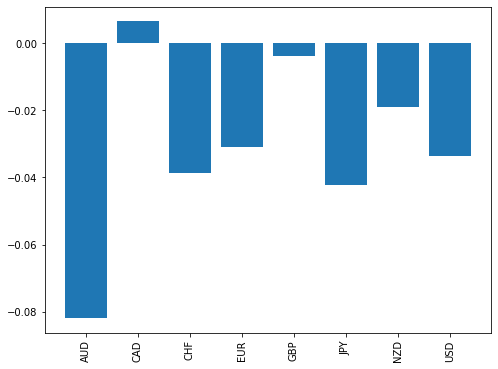

In [144]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [145]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/1000
2431/2431 [==============================] - 6s 2ms/step - loss: 1.0141 - mean_absolute_error: 0.6268 - val_loss: 0.5263 - val_mean_absolute_error: 0.4521
Epoch 2/1000
2431/2431 [==============================] - 5s 2ms/step - loss: 1.0012 - mean_absolute_error: 0.6219 - val_loss: 0.5268 - val_mean_absolute_error: 0.4516
Epoch 3/1000
695/695 [==============================] - 1s 2ms/step - loss: 0.5278 - mean_absolute_error: 0.4518


In [153]:
CONV_WIDTH = 240

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['AUD'])

conv_window

Total window size: 241
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

Text(0.5, 1.0, 'Given 240 hours of inputs, predict 1 hour into the future.')

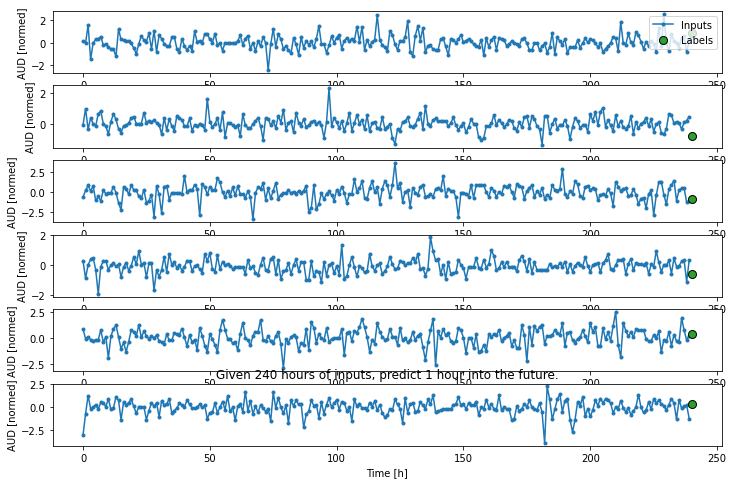

In [154]:
conv_window.plot()

plt.title(f"Given {CONV_WIDTH} hours of inputs, predict 1 hour into the future.")

In [159]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [160]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)


Input shape: (32, 240, 8)
Output shape: (32, 1, 1)


In [161]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

687/687 [==============================] - 1s 2ms/step - loss: 0.5723 - mean_absolute_error: 0.4863


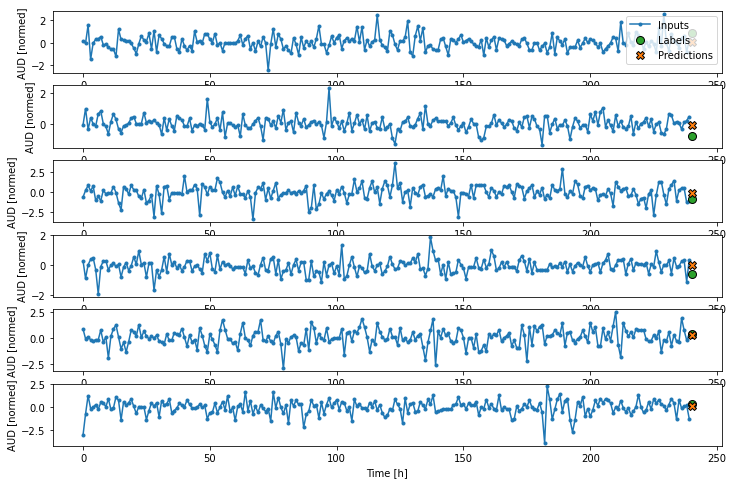

In [162]:
conv_window.plot(multi_step_dense)

In [163]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 8)

ValueError:Exception encountered when calling layer "sequential_2" (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 1920, but received input with shape (32, 192)

Call arguments received by layer "sequential_2" (type Sequential):
  • inputs=tf.Tensor(shape=(32, 24, 8), dtype=float32)
  • training=None
  • mask=None


In [164]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [165]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 240, 8)
Output shape: (32, 1, 1)


In [166]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

  1/687 [..............................] - ETA: 48s - loss: 0.7709 - mean_absolute_error: 0.5787

687/687 [==============================] - 1s 2ms/step - loss: 0.5757 - mean_absolute_error: 0.4871


In [170]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['AUD'])

wide_conv_window

Total window size: 264
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

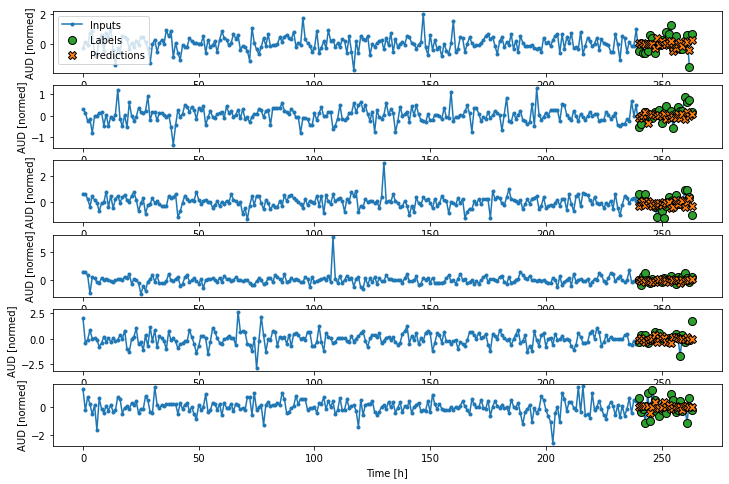

In [171]:
wide_conv_window.plot(conv_model)

In [172]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [173]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

694/694 [==============================] - 3s 4ms/step - loss: 0.5666 - mean_absolute_error: 0.4610


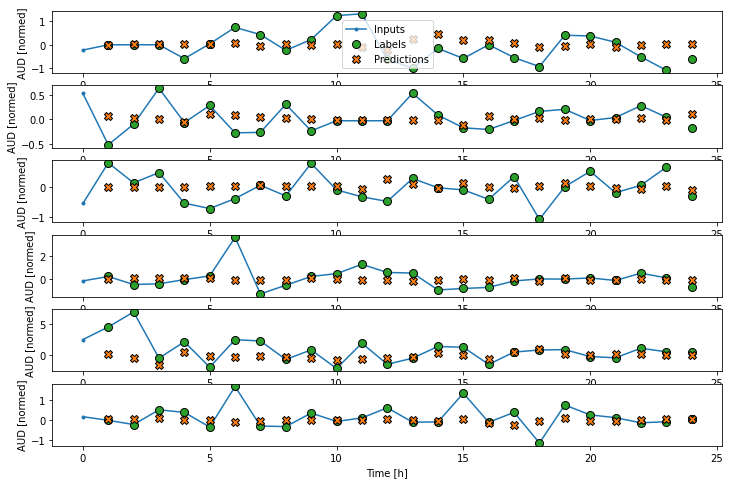

In [174]:
wide_window.plot(lstm_model)

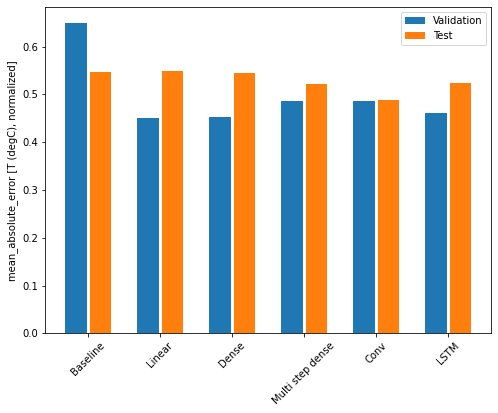

In [175]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [176]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.5468
Linear      : 0.5498
Dense       : 0.5447
Multi step dense: 0.5229
Conv        : 0.4875
LSTM        : 0.5242


In [177]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 8)
Labels shape (batch, time, features): (32, 24, 8)


In [178]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [179]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

694/694 [==============================] - 1s 1ms/step - loss: 1.0552 - mean_absolute_error: 0.6653


In [180]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [181]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

695/695 [==============================] - 1s 1ms/step - loss: 0.5247 - mean_absolute_error: 0.4650


In [182]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

694/694 [==============================] - 3s 4ms/step - loss: 0.5357 - mean_absolute_error: 0.4684

CPU times: user 4min 45s, sys: 1min 5s, total: 5min 51s
Wall time: 1min 46s


In [183]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

UsageError: Line magic function `%%time` not found.


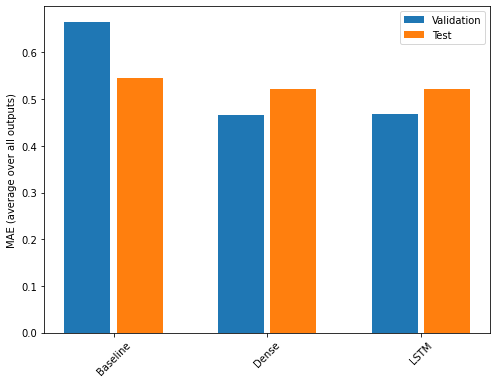

In [184]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [185]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.5445
Dense          : 0.5222
LSTM           : 0.5207


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

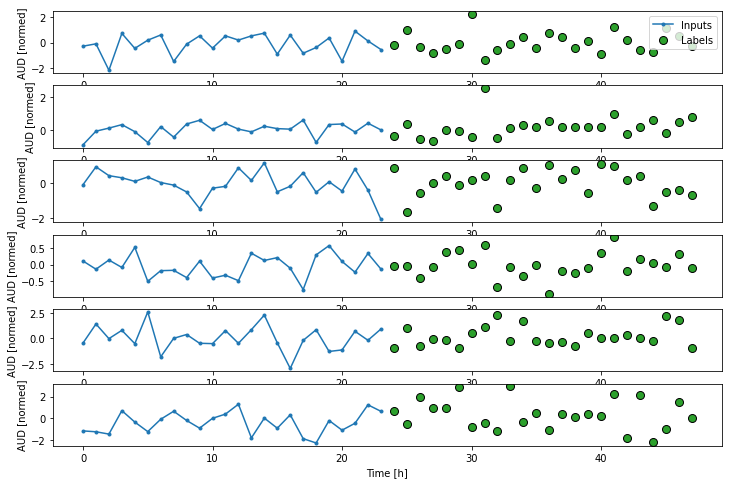

In [192]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

693/693 [==============================] - 1s 1ms/step - loss: 1.0465 - mean_absolute_error: 0.6870


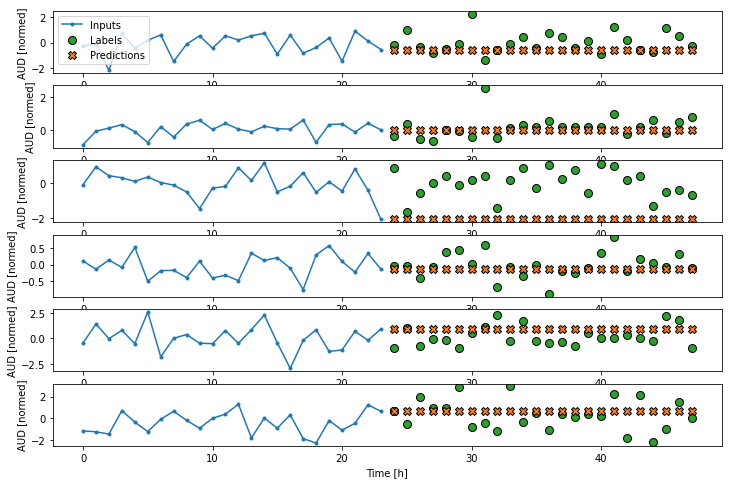

In [193]:
class MultiStepLastBaseline(tf.keras.Model):
    
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

693/693 [==============================] - 1s 1ms/step - loss: 1.0397 - mean_absolute_error: 0.6697


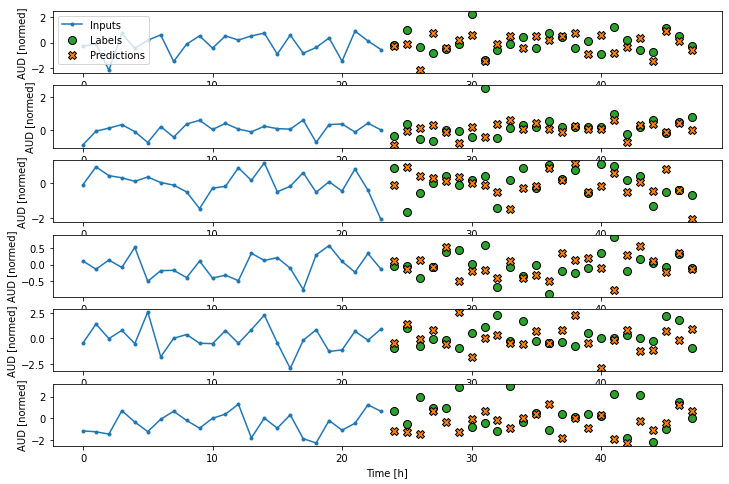

In [194]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

In [91]:

from datetime import datetime
from datetime import timedelta


datetime.utcnow()
# add time labels

ccys = y.columns

X = y

X['hour'] = X.index.hour
X['weekday'] = X.index.weekday
X['hour'] = X.index.hour
X['month'] = X.index.month
X['day'] = X.index.day


In [94]:

for dt in X.index:
    if dt.hour == 12:
        for ccy in ccys:
            last_dt = dt - timedelta(days=1)
            print(ccy)
            print(dt, last_dt, X[ccy][dt])



AUD
2005-01-03 12:00:00+00:00 2005-01-02 12:00:00+00:00 99.79885022401425
CAD
2005-01-03 12:00:00+00:00 2005-01-02 12:00:00+00:00 99.99885612465962
CHF
2005-01-03 12:00:00+00:00 2005-01-02 12:00:00+00:00 100.14077058278032
EUR
2005-01-03 12:00:00+00:00 2005-01-02 12:00:00+00:00 100.05910174203343
GBP
2005-01-03 12:00:00+00:00 2005-01-02 12:00:00+00:00 99.81191591181738
JPY
2005-01-03 12:00:00+00:00 2005-01-02 12:00:00+00:00 100.08757984805776
NZD
2005-01-03 12:00:00+00:00 2005-01-02 12:00:00+00:00 99.85987508106622
USD
2005-01-03 12:00:00+00:00 2005-01-02 12:00:00+00:00 100.2360539346552
AUD
2005-01-04 12:00:00+00:00 2005-01-03 12:00:00+00:00 99.8563759524021
CAD
2005-01-04 12:00:00+00:00 2005-01-03 12:00:00+00:00 100.0069982383416
CHF
2005-01-04 12:00:00+00:00 2005-01-03 12:00:00+00:00 99.59653132876576
EUR
2005-01-04 12:00:00+00:00 2005-01-03 12:00:00+00:00 99.76663769394077
GBP
2005-01-04 12:00:00+00:00 2005-01-03 12:00:00+00:00 99.76028794043948
JPY
2005-01-04 12:00:00+00:00 2005-0

In [95]:

ccys

Index(['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'JPY', 'NZD', 'USD'], dtype='object')